In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr, ttest_ind
from tools import min_max_normalization, case_selection

from datetime import datetime

DATE = datetime.today().strftime("%Y-%m-%d")

In [15]:
NEGATIVES = ("SH.DYN.MORT", "SH.TBS.INCD")
PROXIES_WEIGHT = {
    'MS.MIL.TOTL.TF.ZS': 1, # Armed forces personnel (% of total labor force)
    'MS.MIL.XPND.GD.ZS': 0.5, # Military expenditure (% of GDP)
    
    'EG.ELC.ACCS.RU.ZS': 0.5, # Access to electricity, rural (% of rural population)
    'EG.USE.ELEC.KH.PC': 1, # Electric power consumption (kWh per capita)
    'SH.DYN.MORT': 1, # Mortality rate, under-5 (per 1,000 live births)
    'SH.MED.BEDS.ZS': 1, # Hospital beds (per 1,000 people)
    'SH.TBS.INCD': 1, # Incidence of tuberculosis (per 100,000 people)
    'IS.RRS.PASG.KM': 0.5, # Railways, passengers carried (million passenger-km)
    'SH.H2O.BASW.ZS': 2, # People using at least basic drinking water services (% of population)
    'SH.H2O.SMDW.ZS': 0.5, # People using safely managed drinking water services (% of population)
    #'GC.TAX.TOTL.GD.ZS': 1, # Tax revenue (% of GDP)
    #'IQ.CPA.FISP.XQ': 1 # CPIA fiscal policy rating (1=low to 6=high)
}

YEARS = (2000, 2003, 2004, 2005, 2009, 2010, 2014)
SUCCESSFUL_TRANSITION = ("SRB", "UKR", "GEO")

In [28]:
def stateness_calculation(df, selected_cases=True):
    
    dataset = df.copy()
    dataset["proxy_weight"] = dataset["id"].map(PROXIES_WEIGHT)
    
    positives = dataset.loc[~dataset["id"].isin(NEGATIVES)].copy()
    negatives = dataset.loc[dataset["id"].isin(NEGATIVES)].copy()
    
    positives["norm"] = positives.groupby(["year", "id"])["value"].transform(min_max_normalization)
    negatives["norm"] = negatives.groupby(["year", "id"])["value"].transform(min_max_normalization, reverse=True)
    stateness = pd.concat([positives, negatives], ignore_index=False).sort_values(["year", "id"])
    
    stateness["proxy_score"] = stateness["norm"] * stateness["proxy_weight"] 
    g = stateness.groupby(["year", "iso3"], as_index=False)["proxy_score"].sum()
    g["stateness"] = g["proxy_score"] / sum(PROXIES_WEIGHT.values()) * 100
    g["successful_transition"] = g["iso3"].isin(SUCCESSFUL_TRANSITION).astype(int)
    g["approach"] = "max definition"
    g.drop("proxy_score", axis=1, inplace=True)
    
    return case_selection(g) if selected_cases else g

In [29]:
data = pd.read_excel("./../data/interim/world-bank-data_2020-05-27 22_30.xlsx")
df = data.loc[data["year"].isin(YEARS) & data["id"].isin(PROXIES_WEIGHT.keys())].copy()

In [30]:
# show results for all countries
stateness_calculation(df, selected_cases=False)

,year,iso3,stateness,successful_transition,approach
0,2000,ARM,55.988853,0,max definition
1,2000,AZE,37.981956,0,max definition
2,2000,BLR,74.435477,0,max definition
3,2000,EST,70.351927,0,max definition
4,2000,GEO,34.722504,1,max definition
...,...,...,...,...,...
107,2014,SRB,49.805010,1,max definition
108,2014,TJK,8.705784,0,max definition
109,2014,TKM,44.016678,0,max definition
110,2014,UKR,50.456705,1,max definition


In [31]:
# show results for selected countries
stateness_calculation(df, selected_cases=True)

,year,iso3,stateness,successful_transition,approach
11,2000,SRB,59.546044,1,max definition
20,2003,GEO,37.376371,1,max definition
46,2004,UKR,60.259773,1,max definition
54,2005,KGZ,31.021004,0,max definition
73,2009,MDA,37.780018,0,max definition
86,2010,KGZ,27.388134,0,max definition
110,2014,UKR,50.456705,1,max definition


In [32]:
max_definition = stateness_calculation(df, selected_cases=True)
max_definition.to_excel(f"./../data/interim/max-definition_{DATE}.xlsx", index=False)

---

In [33]:
rcParams["font.size"] = 10
rcParams["figure.figsize"] = 16, 10

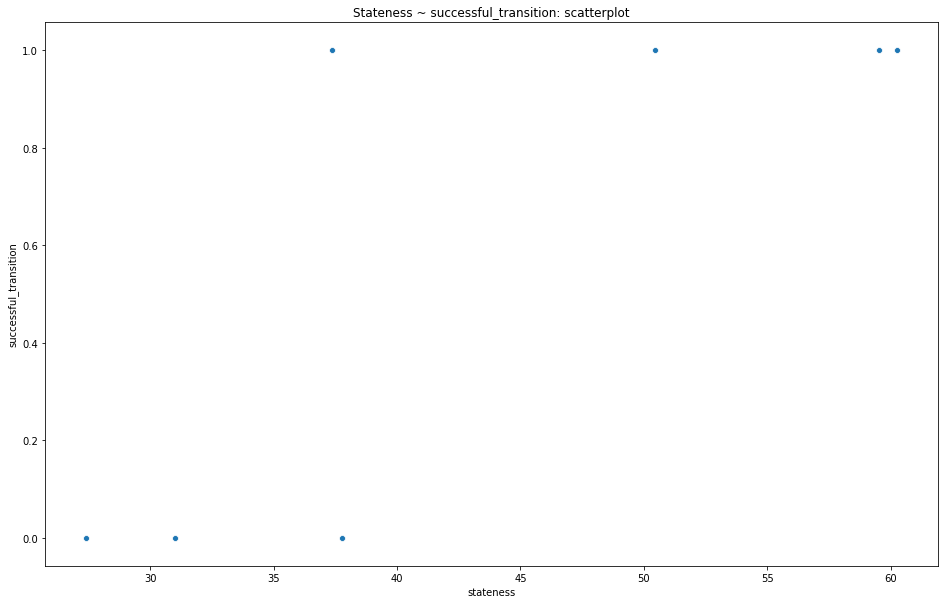

In [34]:
fig = sns.scatterplot(x="stateness", y="successful_transition", data=max_definition)
fig.set_title("Stateness ~ successful_transition: scatterplot")
plt.show()

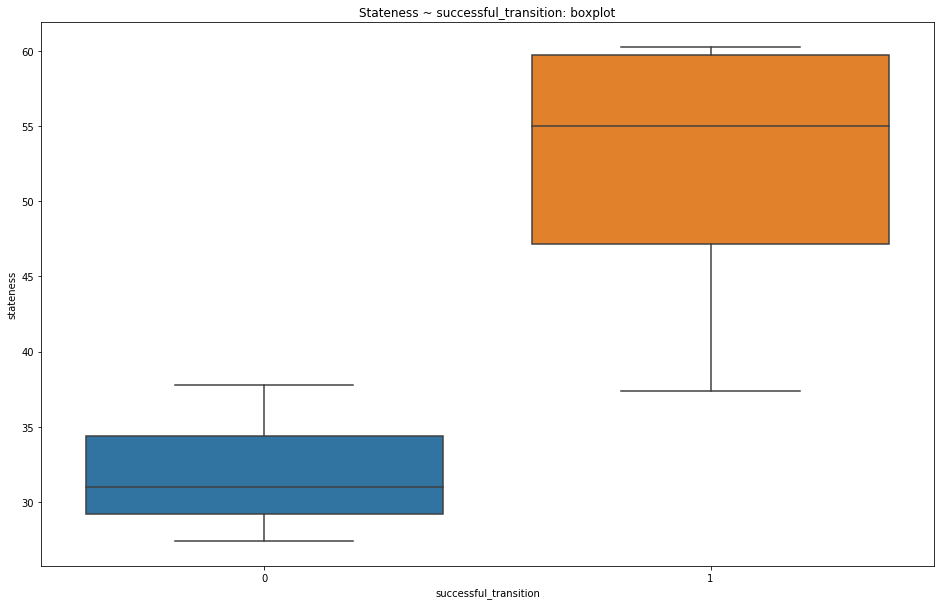

In [35]:
fig = sns.boxplot(x="successful_transition", y="stateness", data=max_definition)
fig.set_title("Stateness ~ successful_transition: boxplot")
plt.show()

In [36]:
statistic, pvalue = ttest_ind(max_definition["stateness"], max_definition["successful_transition"])

In [37]:
statistic

8.47047400291889

In [38]:
pvalue

2.0847007658262208e-06

In [39]:
pvalue < 0.01

True